<h2> (1) Import all relevant libraries, layer and classes <h2>


In [1]:
# General
import os
import time

# Python libraries
import numpy as np, collections
import matplotlib.pyplot as plt
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

# Keras
import keras.backend as k
from keras import optimizers
from keras import losses, regularizers
from keras import initializers
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot

# CoreML 
import coremltools

# Scikit-learn
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

# Seaborn
import seaborn as sn

# Locale methods and properties
from model import create_model
from callbacks import get_callbacks 
from auxilary_functions import time_stamp
from load_data import load_and_store_data, load_stored_data 
from data_augmentation import normalize_data, standardize_data
from plot_pose_sequence import plot_trainings_data, plot_test_data
from plot_confusion_matrix import print_confusion_matrix 
from plot_trainings_history import plot_loss_acc
from plot_data_distribution import plot_data_distribution

Using TensorFlow backend.
W0720 19:32:19.255435 139883762485056 __init__.py:71] TensorFlow version 1.14.0 detected. Last version known to be fully compatible is 1.13.1 .
/home/sami/Desktop/iOS-Praktikum-GOALPLAY/Model/plot_trainings_history.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/sami/anaconda3/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sami/anaconda3/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sami/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sami/.local/lib/python3.6/site-packages/traitlets/

<h2> (2) Load and prepare goalkeeper pose data <h2>

In [2]:
DATA_PATH = "./stored_data/4_classes/"

# Load data from .npy files 
# (Framrates/Poses-per-sequence: '5' / '10' / '15' / '30' / '45' / '60' / '75' / '90')
#X_raw, y_raw = load_stored_data(dir_path=DATA_PATH, num_poses='90')
# X = [samples, timesteps, features]
# y = [samples, labels]
X_raw, y_raw = load_and_store_data(num_poses=5, X_filename_prefix='X_data_5p', y_filename_prefix='y_data_5p')

# Augment data
X, y, range_mean, range_std,data_augmentation = standardize_data(X_raw, y_raw)
#X, y, data_augmentation = normalize_data(X_raw, y_raw)

# Split dataset into train and test set (and shuffle them)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Get one hot vector from labels
y_train = to_categorical(y_train_temp, num_classes=6)
y_test = to_categorical(y_test_temp, num_classes=6)

# Input features
INPUT = [
    "HEAD_X",
    "HEAD_Y_",
    "BODY_X",
    "BODY_Y",
    "LEFT_ARM_X",
    "LEFT_ARM_Y",
    "RIGHT_ARM_X",
    "RIGHT_ARM_Y",
    "LEFT_LEG_X",
    "LEFT_LEG_Y",
    "RIGHT_LEG_X",
    "RIGHT_LEG_Y",
]

# Output classes
LABELS = [    
    "STAND_BY",
    "LEFT_DIVE",
    "RIGHT_DIVE",
    "HIGH_CATCH",
]

# Some debugging info
print("---------------------------------------")
print("---------------------------------------")
print("Bsic information regardin the data:")
print("---------------------------------------")
print("Trainings data...")
print("... input shape=" + str(X_train.shape))
print("... target shape=" + str(y_train.shape))
print("---------------------------------------")
print("Test data...")
print("... input shape=" + str(X_test.shape))
print("... target shape=" + str(y_test.shape))
print("---------------------------------------")
print("---------------------------------------")

(1327, 5, 26)
---------------------------------------
---------------------------------------
Bsic information regardin the data:
---------------------------------------
Trainings data...
... input shape=(1194, 5, 26)
... target shape=(1194, 6)
---------------------------------------
Test data...
... input shape=(133, 5, 26)
... target shape=(133, 6)
---------------------------------------
---------------------------------------


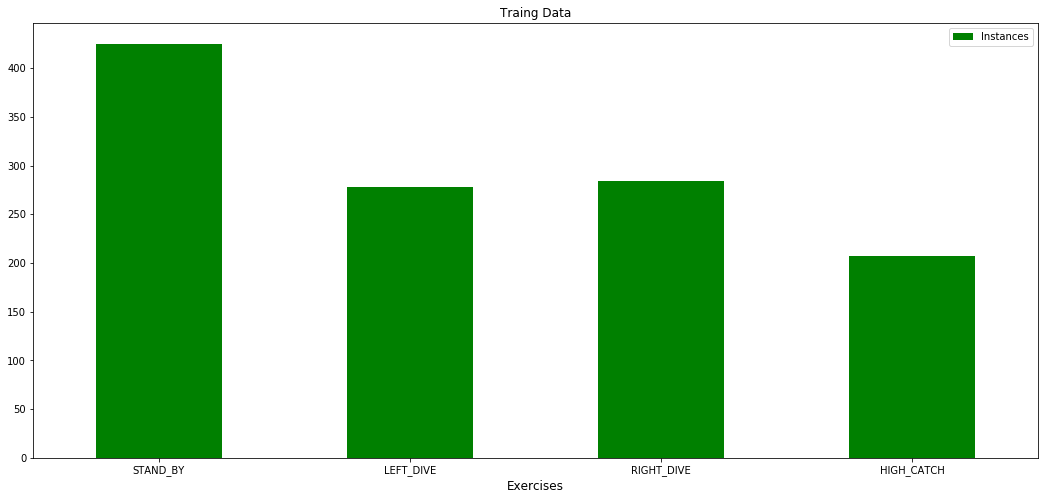

In [3]:
# Plot data distribution (trainings data)
plot_data_distribution(y_train_temp, labels=LABELS)

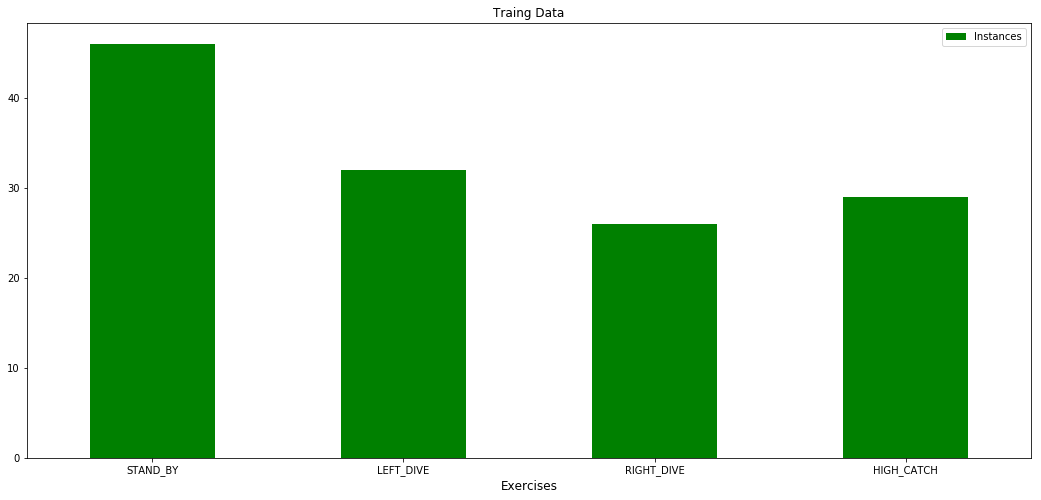

In [4]:
# Plot data distribution (teest data)
plot_data_distribution(y_test_temp, labels=LABELS)

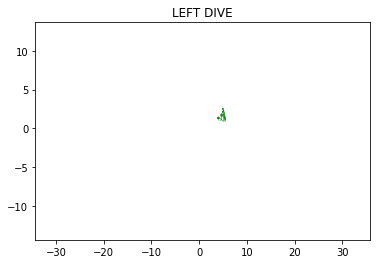

In [5]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=25,  data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

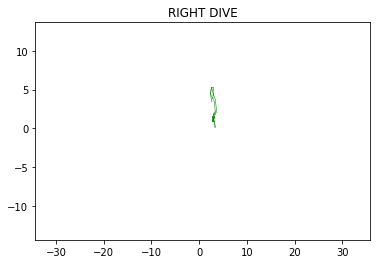

In [6]:
# Plot one sequence of poses range_mean, range_std
plot_trainings_data(X_train, y_train_temp, sample=845, data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

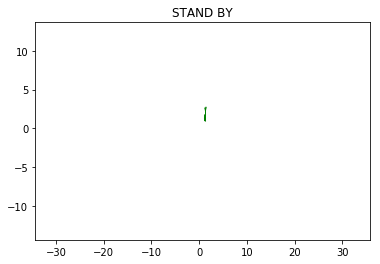

In [7]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=103, data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

<h2> (3) Define constants and additional parameters <h2>

In [8]:
# Input Data
n_timesteps = X_train.shape[1] #len(X_train[1])  # n-timesteps per series per series
n_features = X_train.shape[2] #len(X_train[0][0])  # n input parameters per timestep

# LSTM Neural Network's internal structure
input_shape = (n_timesteps, n_features)
n_mem_units = 128 # Hidden layer num of features
n_classes = len(LABELS) # n classes (should go up, or should go down)

# Training - Hyperparameter  
learning_rate = 0.001
optimizer = optimizers.RMSprop(lr=learning_rate, decay=0.5) 
n_epochs = 30  
batch_size = 128

<h2> (4) Define and build sequence model <h2>

In [9]:
# Create model
model = create_model(input_shape, dropout=True)

# Build model 
model.compile(loss=losses.categorical_crossentropy, 
              optimizer=optimizer,
              metrics=['accuracy'])

# Print model details/summary
model.summary()

# Get curent time stamp
time_stamp = time_stamp()

W0720 19:32:35.734975 139883762485056 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 19:32:35.737611 139883762485056 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 19:32:35.763743 139883762485056 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 19:32:36.823601 139883762485056 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 5, 26)             0         
_________________________________________________________________
LSTM_Layer1 (LSTM)           (None, 5, 90)             42120     
_________________________________________________________________
LSTM_Layer2 (LSTM)           (None, 5, 90)             65160     
_________________________________________________________________
LSTM_Layer3 (LSTM)           (None, 90)                65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90)                0         
_________________________________________________________________
Feature_Layer1 (Dense)       (None, 96)                8736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
__________

<h2> (5) Record and store process of models/training <h2>

In [10]:
# Tensorboard
logdir = './training_history/logs/' + time_stamp

# Create directory which will contain trained models 
model_directory = "./training_history/saved_models/" + time_stamp

# Generate callback list 
callbacks = get_callbacks(model_directory, logdir, time_stamp)

<h2> (6) Train model <h2>

In [11]:
# Weight classes to overcome the unbalanced data
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

# Reshape model fo CoreML model 
reshaped_X_train = X_train.reshape(X_train.shape[0],-1)

# Train model on trainings data 
history = model.fit(reshaped_X_train, 
                    y_train, 
                    verbose=2, 
                    shuffle=True, 
                    epochs=n_epochs, 
                    validation_split=0.1, 
                    batch_size=batch_size, 
                    callbacks=callbacks,
                    class_weight=class_weights)

print(model.metrics_names)
print(model.evaluate(reshaped_X_train, y_train))

W0720 19:32:37.503639 139883762485056 deprecation.py:323] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1074 samples, validate on 120 samples
Epoch 1/30
 - 6s - loss: 1.6443 - acc: 0.3585 - val_loss: 1.3459 - val_acc: 0.5583
Epoch 2/30
 - 1s - loss: 1.4046 - acc: 0.4674 - val_loss: 1.2643 - val_acc: 0.6000
Epoch 3/30
 - 1s - loss: 1.3352 - acc: 0.5205 - val_loss: 1.2163 - val_acc: 0.6750
Epoch 4/30
 - 1s - loss: 1.2829 - acc: 0.5596 - val_loss: 1.1882 - val_acc: 0.7000
Epoch 5/30
 - 1s - loss: 1.2608 - acc: 0.5866 - val_loss: 1.1610 - val_acc: 0.7083
Epoch 6/30
 - 1s - loss: 1.2344 - acc: 0.6043 - val_loss: 1.1373 - val_acc: 0.7250
Epoch 7/30
 - 1s - loss: 1.2153 - acc: 0.5912 - val_loss: 1.1236 - val_acc: 0.7250
Epoch 8/30
 - 1s - loss: 1.1872 - acc: 0.6145 - val_loss: 1.1104 - val_acc: 0.7250
Epoch 9/30
 - 1s - loss: 1.1782 - acc: 0.6210 - val_loss: 1.0950 - val_acc: 0.7250
Epoch 10/30
 - 1s - loss: 1.1624 - acc: 0.6406 - val_loss: 1.0834 - val_acc: 0.7333
Epoch 11/30
 - 1s - loss: 1.1401 - acc: 0.6453 - val_loss: 1.0750 - val_acc: 0.7250
Epoch 12/30
 - 1s - loss: 1.1341 - acc

<h2> (7) Predict and evaluate <h2>

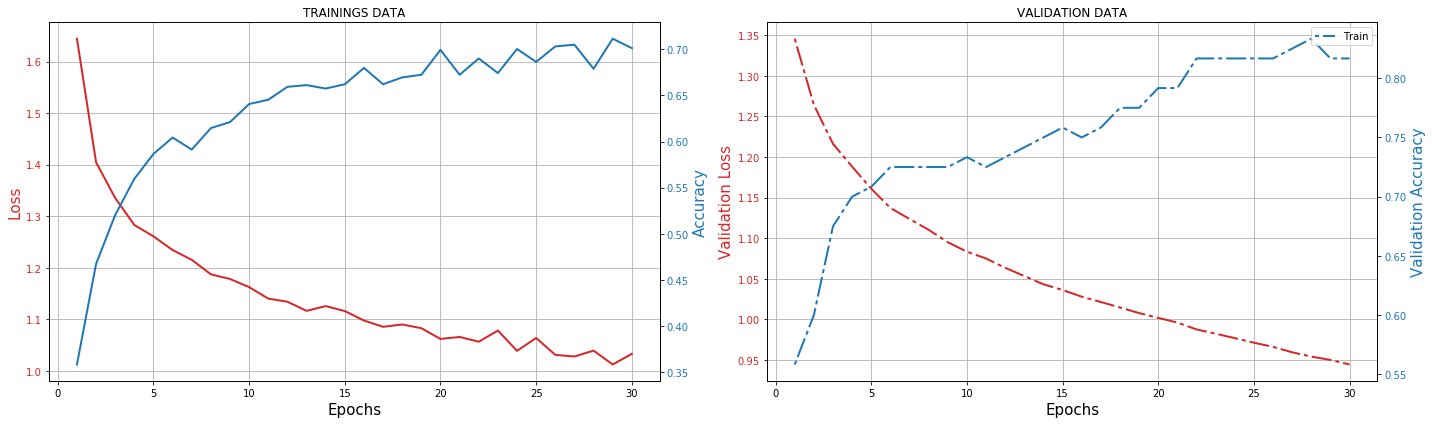

['loss', 'acc']
Train accuracy: [0.9234130947633804, 0.7713567837199174]
Test accuracy: [0.9719093607780629, 0.7894736846586815]


In [12]:
# Plot history 
plot_loss_acc(model)

# Reshape X_test data
reshaped_X_test = X_test.reshape(X_test.shape[0],-1)

# Evaluate the model
train_acc = model.evaluate(reshaped_X_train, y_train, verbose=0)
test_acc = model.evaluate(reshaped_X_test, y_test, verbose=0)
print(model.metrics_names)
print('Train accuracy: ' + str(train_acc))
print('Test accuracy: ' + str(test_acc))

In [13]:
y_predicted_classes = model.predict_classes(reshaped_X_test)
y_prediction_prob = model.predict(reshaped_X_test)

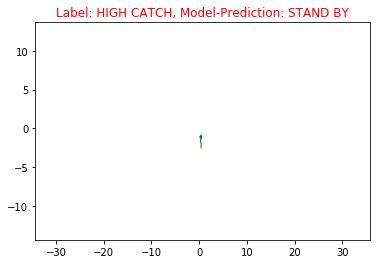

In [14]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=69, data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

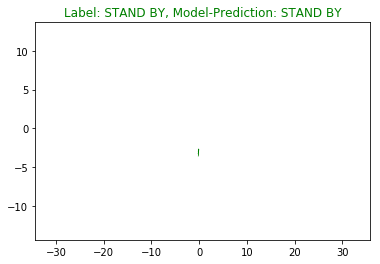

In [15]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=14, data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

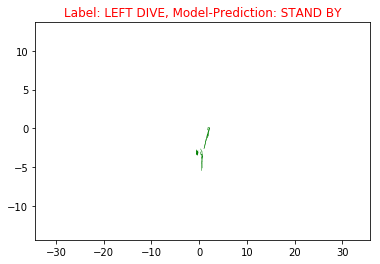

In [16]:
# Plot one sequence of poses and classify the containing exercises
plot_test_data(X_test, y_predicted_classes, y_test_temp, sample=9, data_augmentation=data_augmentation, range_mean=range_mean, range_std=range_std)

<h2> (8) Save model <h2>

In [17]:
# Save trained model
saved_model = model_directory + "/activity_recognition_model.h5"
model.save(saved_model)

In [18]:
# Convert trained model into CoreML
coreml_model = coremltools.converters.keras.convert(saved_model, 
                                                    class_labels=LABELS, 
                                                    input_names=['pose'])

# Store CoreML model 
coreml_model.save(model_directory + "/activity_recognition_model.mlmodel")

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x7f38d8be2278>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7f38d8be2240>
2 : LSTM_Layer1, <keras.layers.recurrent.LSTM object at 0x7f38d8be22b0>
3 : LSTM_Layer2, <keras.layers.recurrent.LSTM object at 0x7f38d8be2550>
4 : LSTM_Layer3, <keras.layers.recurrent.LSTM object at 0x7f38d7c88978>
5 : Feature_Layer1, <keras.layers.core.Dense object at 0x7f38b80d1c50>
6 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7f3890215f28>
7 : activation_1, <keras.layers.core.Activation object at 0x7f38d8be2390>
8 : Feature_Layer2, <keras.layers.core.Dense object at 0x7f38900a94a8>
9 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7f388476fe48>
10 : activation_2, <keras.layers.core.Activation object at 0x7f3890235a20>
11 : Output_Layer, <keras.layers.core.Dense object at 0x7f38846b6d30>
12 : Output_Layer__activation__, <keras.layers.core.Activation object a

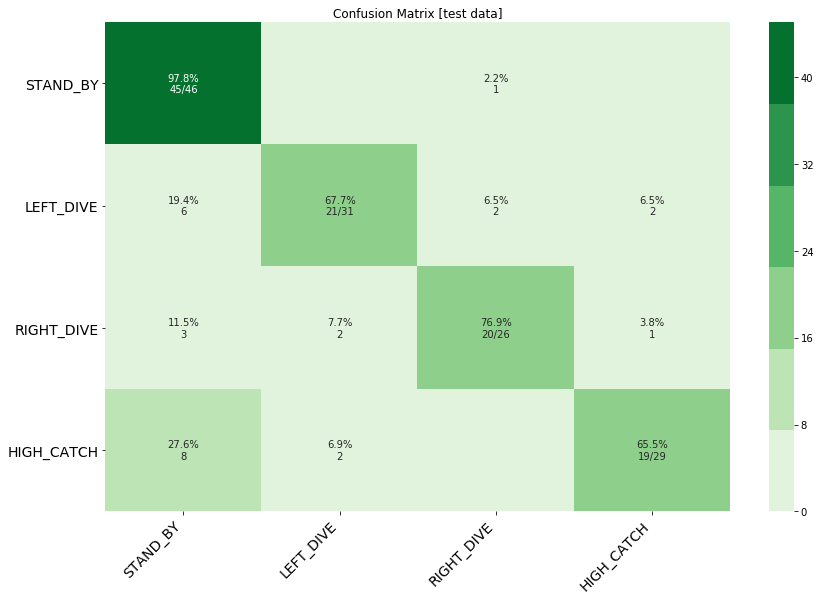

In [19]:
# Generate confusion matrix test data 
matrix = metrics.confusion_matrix(y_test_temp, y_predicted_classes, labels=np.unique(y_test_temp))
print_confusion_matrix(matrix, LABELS, figsize = (14,9), cmap=sn.color_palette("Greens"))